# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# pip install wordcloud

# Read CSVs

Datasets are available on the link in readME. Change the paths as needed.

In [3]:
path_movies ='../Datasets/movies.csv'
path_ratings = '../Datasets/ratings.csv' 
path_tags = '../Datasets/tags.csv' 

movies = pd.read_csv(path_movies)
ratings = pd.read_csv(path_ratings)
tags = pd.read_csv(path_tags)

# Treating Movies Dataset

## Data Understanding

Basic stats of Movies Dataset. No null falues were found, so no missing data handling was made.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [6]:
movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [8]:
movies.nunique()

movieId    62423
title      62325
genres      1639
dtype: int64

In [9]:
# (Some movies are duplicated, but that doesn't seem to affect the overall figure for now)

In [10]:
movies['title'].value_counts()

title
The Void (2016)                                2
Seven Years Bad Luck (1921)                    2
Clear History (2013)                           2
Enron: The Smartest Guys in the Room (2005)    2
Deranged (2012)                                2
                                              ..
$ellebrity (Sellebrity) (2012)                 1
Macabre (Macabro) (1980)                       1
Punk's Dead: SLC Punk! 2 (2014)                1
Chinese Hercules (1973)                        1
Women of Devil's Island (1962)                 1
Name: count, Length: 62325, dtype: int64

In [11]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

## Genre splitting for EDA

In [12]:
# Separating genres to count them and do some EDA from that
movie_genres = movies['genres'].str.split(pat ='|', expand=True).fillna(0)
movie_genres.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
movie_genres['genre_count'] = movie_genres.iloc[:, 0:10].astype(bool).sum(axis=1)
genre_count_column = movie_genres.pop('genre_count')
movie_genres.insert(0, 'genre_count', genre_count_column)
movie_genres.head()

,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,2,Comedy,Romance,0,0,0,0,0,0,0,0
3,3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,1,Comedy,0,0,0,0,0,0,0,0,0


## Year Column added for EDA

In [13]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = movies['year'].fillna(0).astype('int64')
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


### Putting all of the columns together

In [14]:
movies = pd.concat([movies, movie_genres], axis=1)
movies.head()

,movieId,title,genres,year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,1,Comedy,0,0,0,0,0,0,0,0,0


# Data understanding about genres 

### Num of unique Genres

In [15]:
# Num of genres
all_genres = pd.concat([movie_genres['genre1'], movie_genres['genre2'], movie_genres['genre3'],
                        movie_genres['genre4'], movie_genres['genre5'], movie_genres['genre6'],
                        movie_genres['genre7'], movie_genres['genre8'], movie_genres['genre9'],
                        movie_genres['genre10']])

num_genres = len(all_genres.unique())
num_genres

21

### Movie with the highest number of genres

In [16]:
movies.genre_count.max()
movies_max = movies[movies['genre_count'] == 10]
movies_max

,movieId,title,genres,year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
15389,81132,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,2010,10,Action,Adventure,Comedy,Crime,Drama,Film-Noir,Horror,Mystery,Thriller,Western


### List of genres and genre count

Here we dropped genre '0' because that were the values filled by the number '0' when splitting genres.

In [17]:
list_of_genres = []

unique_genres = all_genres.unique()
for genre in unique_genres:
    list_of_genres.append(genre)

list_of_genres

['Adventure',
 'Comedy',
 'Action',
 'Drama',
 'Crime',
 'Children',
 'Mystery',
 'Documentary',
 'Animation',
 'Thriller',
 'Horror',
 'Fantasy',
 'Western',
 'Film-Noir',
 'Romance',
 'War',
 'Sci-Fi',
 'Musical',
 'IMAX',
 '(no genres listed)',
 0]

In [18]:
genre_counts = all_genres.value_counts().reset_index()
genre_counts = genre_counts.rename(columns={'index': 'genre', 'count': 'count'})
genre_counts.drop(0, inplace = True)
genre_counts

,genre,count
1,Drama,25606
2,Comedy,16870
3,Thriller,8654
4,Romance,7719
5,Action,7348
6,Horror,5989
7,Documentary,5605
8,Crime,5319
9,(no genres listed),5062
10,Adventure,4145


In [19]:
average_genre_count = movies['genre_count'].mean()
average_genre_count

1.7991285263444563

In [20]:
average_year = movies['year'].mean()
average_year

1978.9607676657643

# EDA

## Genre

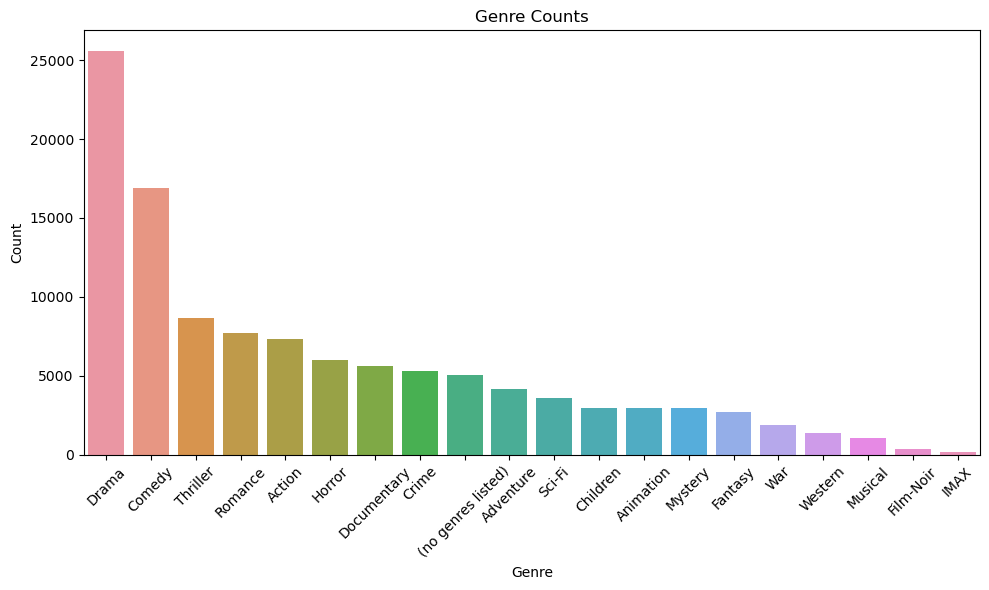

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='genre', y='count', data=genre_counts)
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Treating Ratings dataset

In [22]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
